## Import modules and set up a Dask cluster.

In [1]:
from dask.distributed import Client, wait
import dask
from xorca_lonlat2ij import get_ij
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from xorca.lib import load_xorca_dataset
import xarray as xr
import xorca_brokenline as bl
from matplotlib import colors as c

In [2]:
plt.rcParams['figure.figsize'] = [20, 7]
plt.rcParams.update({'font.size': 17})

In [3]:
client = Client(n_workers=1, threads_per_worker=8, memory_limit=12e9)
client

/opt/tljh/user/envs/py3_euler_brokenline/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:44473 Dashboard: /user/workshop001/proxy/46169/status,Cluster Workers: 1 Cores: 8 Memory: 12.00 GB


### LOADING files

In [4]:
global_data_path = Path("/data/iAtlantic/")
#experiment_id = "INALT20.L46-KFS104"
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix="1_" #El nest tiene más resolución, está cada menos distancia

erda_data_path = Path("/data/erda/")

# chunk sizes
chu_x = 500 #si pongo None coge toda la matriz y tarda demasiado!
chu_y = 700 
chu_z = 23
chu_t = 3 #o poner 1 en cada 1

# region
#z = 500
#j_bnds = slice(1500, 2000)
#i_bnds = slice(500, 1250)

#####
#saga lon 9, lat -32,-24

In [33]:
MESH_MASK_files = list(sorted(
    (global_data_path / "mask" / experiment_id).glob(
        f"{nest_prefix}mesh_mask.nc"
    )
))

U_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(
        f"{nest_prefix}{experiment_id}_1m_2003*_grid_U.nc"
    )
))

V_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(
        f"{nest_prefix}{experiment_id}_1m_2003*_grid_V.nc"
    )
))

print(f"Found {len(MESH_MASK_files)} mesh/mask files, {len(U_files)} U files, and {len(V_files)} V files.")

Found 1 mesh/mask files, 1 U files, and 1 V files and 0 rho files.


In [6]:
#Auxiliary data
ds_mesh_mask = xr.open_mfdataset(
 MESH_MASK_files,
 chunks={
     "z": chu_z,
     "y": chu_y,
     "x": chu_x
 },
 combine='by_coords')
ds_mesh_mask = ds_mesh_mask.squeeze()  # remove degenerate time dim
#ds_mesh_mask = ds_mesh_mask.set_coords(["nav_lat", "nav_lon"])
#fmask = ds_mesh_mask['fmask'].isel(t=0,z=0)
ds_mesh_mask = ds_mesh_mask.expand_dims('t')
ds_mesh_mask = ds_mesh_mask.rename({'nav_lev':'nav_lev_0'})
ds_mesh_mask = ds_mesh_mask.rename({"e3u_0" : "e3u", "e3v_0" : "e3v"})
ds_mesh_mask['nav_lev'] = ds_mesh_mask.nav_lev_0.isel(t=0)
display(ds_mesh_mask)

<xarray.Dataset>
Dimensions:       (t: 1, x: 2404, y: 2499, z: 46)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    nav_lat       (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    nav_lev_0     (t, z) float32 dask.array<chunksize=(1, 23), meta=np.ndarray>
    time_counter  (t) float64 0.0
    tmask         (t, z, y, x) int8 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    umask         (t, z, y, x) int8 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    vmask         (t, z, y, x) int8 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    fmask         (t, z, y, x) int8 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    tmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    umaskutil     (t, y, x) int8 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    vmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    fmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    glamv         (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    glamf         (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    gphit         (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    gphiu         (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    gphiv         (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    gphif         (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    e1t           (t, y, x) float64 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    e1u           (t, y, x) float64 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    e1v           (t, y, x) float64 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    mbathy        (t, y, x) int16 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    misf          (t, y, x) int16 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    isfdraft      (t, y, x) float32 dask.array<chunksize=(1, 700, 500), meta=np.ndarray>
    e3t_0         (t, z, y, x) float64 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    e3u           (t, z, y, x) float64 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    e3v           (t, z, y, x) float64 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    e3w_0         (t, z, y, x) float64 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    gdept_0       (t, z, y, x) float32 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    gdepu         (t, z, y, x) float32 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    gdepv         (t, z, y, x) float32 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    gdepw_0       (t, z, y, x) float32 dask.array<chunksize=(1, 23, 700, 500), meta=np.ndarray>
    gdept_1d      (t, z) float64 dask.array<chunksize=(1, 23), meta=np.ndarray>
    e3t_1d        (t, z) float64 dask.array<chunksize=(1, 23), meta=np.ndarray>
    e3w_1d        (t, z) float64 dask.array<chunksize=(1, 23), meta=np.ndarray>
    depthw        (t, z) float64 dask.array<chunksize=(1, 23), meta=np.ndarray>
  

In [7]:
ds_U = xr.open_mfdataset(
 U_files,
 chunks={
     "time_counter": chu_t,
     "depthu": chu_z,
     "y": chu_y,
     "x": chu_x
 },
 combine='by_coords')
display(ds_U)
#ds_U = ds_U.rename({"time_counter" : "t", "depthu" : "z"})

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depthu: 46, time_counter: 12, x: 2404, y: 2499)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(700, 500), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(700, 500), meta=np.ndarray>
  * depthu                (depthu) float32 3.0467727 9.454049 ... 5875.141
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(3,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2003-01-16T12:00:00 ... 2003-12-16T12:00:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthu_bounds         (depthu, axis_nbounds) float32 dask.array<chunksize=(23, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(3, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(3, 2), meta=np.ndarray>
    vozocrtx              (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 23, 700, 500), meta=np.ndarray>
    sozotaux              (time_counter, y, x) float32 dask.array<chunksize=(3, 700, 500), meta=np.ndarray>
Attributes:
    name:                      1_VIKING20X.L46-KKG36107B_1d_20030101_20030704...
    description:               ocean U grid variables
    title:                     ocean U grid variables
    Conventions:               CF-1.6
    timeStamp:                 2019-Sep-22 10:28:09 GMT
    uuid:                      4ee545ea-a9b7-4e71-ad66-758d82250d8c
    history:                   Mon Sep 23 18:23:03 2019: ncrcat -O -F /gfs2/w...
    NCO:                       4.4.8
    nco_openmp_thread_number:  1

In [8]:
ds_V = xr.open_mfdataset(
 V_files,
 chunks={
     "time_counter": chu_t,
     "depthv": chu_z,
     "y": chu_y,
     "x": chu_x
 },
 combine='by_coords')
display(ds_V)
#ds_U = ds_U.rename({"time_counter" : "t", "depthu" : "z"})


<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depthv: 46, time_counter: 12, x: 2404, y: 2499)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(700, 500), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(700, 500), meta=np.ndarray>
  * depthv                (depthv) float32 3.0467727 9.454049 ... 5875.141
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(3,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2003-01-16T12:00:00 ... 2003-12-16T12:00:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthv_bounds         (depthv, axis_nbounds) float32 dask.array<chunksize=(23, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(3, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(3, 2), meta=np.ndarray>
    vomecrty              (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 23, 700, 500), meta=np.ndarray>
    sometauy              (time_counter, y, x) float32 dask.array<chunksize=(3, 700, 500), meta=np.ndarray>
Attributes:
    name:                      1_VIKING20X.L46-KKG36107B_1d_20030101_20030704...
    description:               ocean V grid variables
    title:                     ocean V grid variables
    Conventions:               CF-1.6
    timeStamp:                 2019-Sep-22 10:28:11 GMT
    uuid:                      9cb4bca3-0aa9-4a04-9ef0-fffca6e1fac4
    history:                   Mon Sep 23 18:23:05 2019: ncrcat -O -F /gfs2/w...
    NCO:                       4.4.8
    nco_openmp_thread_number:  1

## Define section

In [9]:
lon_sa_min=-50
lon_sa_max= 17
lat_sa_min=-30
lat_sa_max=-30

lonv = ds_U.nav_lon.isel(y=0).values
ilonv_min = (np.abs(lonv-lon_sa_min)).argmin()
ilonv_max = (np.abs(lonv-lon_sa_max)).argmin()

latv = ds_U.nav_lat.isel(x=0).values
ilatv_min = (np.abs(latv-lat_sa_min)).argmin()
ilatv_max = (np.abs(latv-lat_sa_max)).argmin()

print('ilon:',ilonv_min,ilonv_max)
print('ilat:',ilatv_min,ilatv_max)

ilon: 968 2308
ilat: 95 95


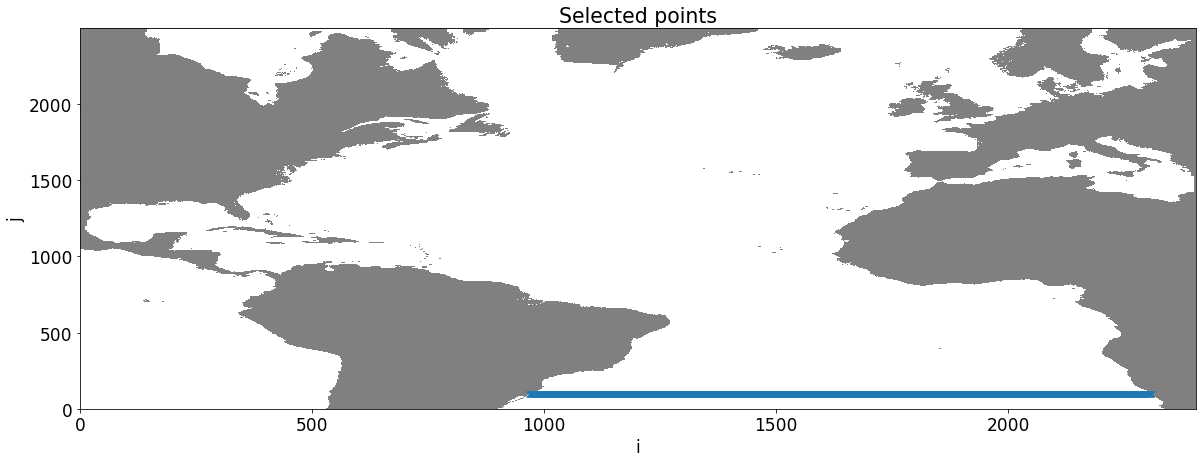

In [10]:
ji_pairs = [
    (ilatv_min, ilonv_min),
    (ilatv_max,ilonv_max)
]

ji = bl.section_indices(ji_pairs=ji_pairs)
jj,ii = zip(*ji)

fmask = ds_mesh_mask['fmask'].isel(z=0,t=0)

fmask.plot(cmap=c.ListedColormap(['gray','white']),add_colorbar=0)
plt.plot(ii,jj,'x')

plt.ylabel("j")
plt.xlabel("i")
plt.title('Selected points');


## Extract Section
bl.shift_grids() interpolates all variables onto the u- and v-points, drops unnecessary coordinate labels and variables and renames depth dimension. <br>
select_section() selects the section defined by ji from gridU_processed and gridV_processed and returns a section.

In [11]:
bl.select_section?

Signature:
bl.select_section(
    ij,
    gridU,
    gridV,
    mesh_hgr=None,
    mesh_zgr=None,
    mask=None,
)
Docstring:
Form a section by selecting quantities at U or V, depending on the
    orientation of each segment.
    We define velocities and transports, that go to the right of the
    progression of the section, as positiv.
    This means that the sign of the velocities depends on the order of the
    input points.
    For each leg, velocities are converted as follows:
        i0_leg < i1_leg -> V*(-1)
        j0_leg > j1_leg -> U*(-1)

Parameters
----------
ij : Iterator of tuples.
    Iterator of n tuples of ji-coordinates defining the secion.
gridU : xarray.Dataset
    Dataset of shape (t,z,y,x) holding variables at U-point.
    Use dataset returned by broken_line.reduce_dataset()
gridV : xarray.Dataset
    Dataset of shape (t,z,y,x) holding variables at V-point.
    Use dataset returned by broken_line.reduce_dataset()
mesh_hgr : xarray.Dataset, optional
    Dataset of 

In [12]:
ji = bl.section_indices(ji_pairs=ji_pairs)
gridU_processed, gridV_processed = bl.shift_grids(gridU=ds_U, gridV=ds_V)
section = bl.select_section(
    ji,gridU_processed,gridV_processed,ds_mesh_mask,ds_mesh_mask,ds_mesh_mask
    ).compute()

Section includes the velocity normal to the section (either U or V, depending on the orientation of each segment), the length and depth of each segment and a land-sea mask variable. 

In [13]:
section

<xarray.Dataset>
Dimensions:       (c: 1340, time_counter: 12, z: 46)
Coordinates:
  * c             (c) float64 4.817e+03 9.634e+03 ... 6.45e+06 6.455e+06
  * z             (z) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 2003-01-16T12:00:00 ... 2003-12-16T12:00:00
Data variables:
    u_normal      (time_counter, z, c) float64 0.1135 0.1142 0.1174 ... 0.0 0.0
    dx            (c) float64 4.817e+03 4.817e+03 ... 4.817e+03 4.817e+03
    dz            (z, c) float64 6.191 6.191 6.191 6.191 ... 250.4 250.4 250.4
    mask          (z, c) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0

In [14]:
ji = bl.section_indices(ji_pairs=ji_pairs)
lji = [tuple(ji2) for ji2 in ji]
sali=np.array(lji)
sali

array([[  95,  968],
       [  95,  969],
       [  95,  970],
       ...,
       [  95, 2306],
       [  95, 2307],
       [  95, 2308]])

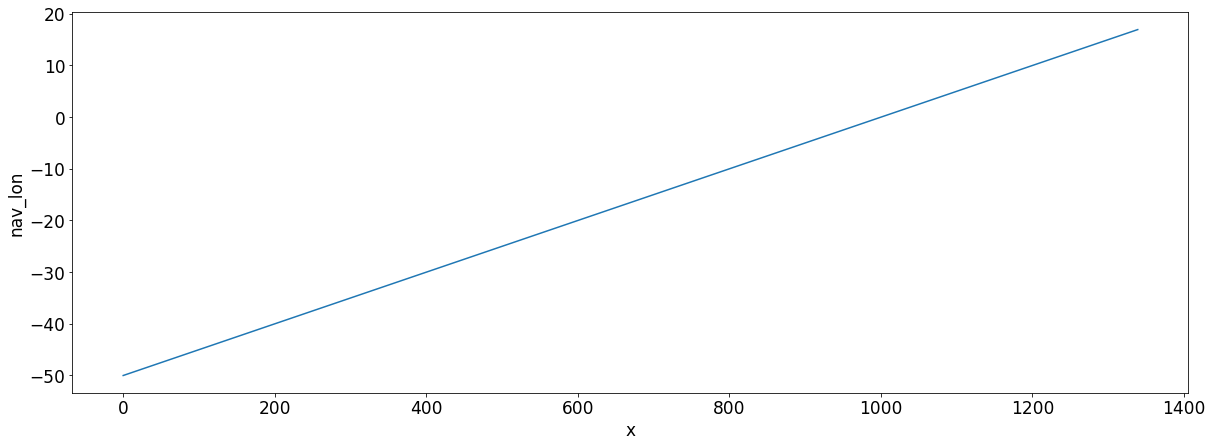

In [15]:
#nav_lat       (t, y, x) 
lon1=ds_mesh_mask.nav_lon.isel(t=0,y=sali[:,0],x=sali[:,1])
lon2=lon1.isel(y=0)[:-1]
lon2.plot();

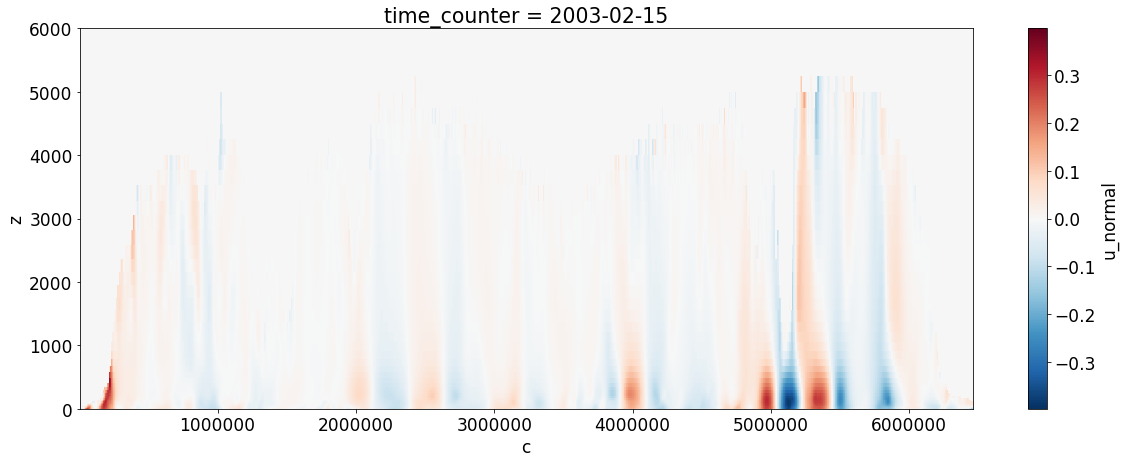

In [16]:
section['u_normal'].isel(time_counter=1).plot();

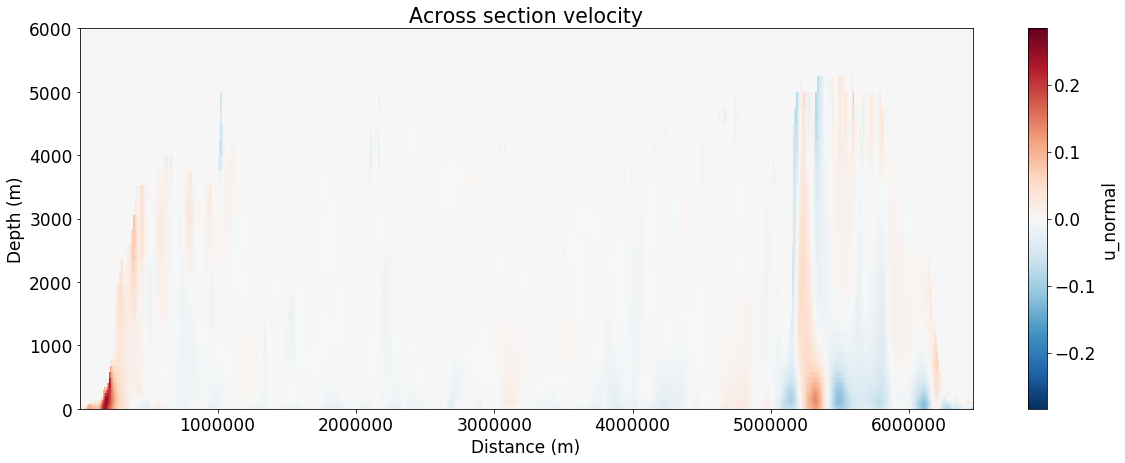

In [17]:
section['u_normal'].mean('time_counter').plot()
#section['mask'].where(section['mask']==0).plot(cmap=c.ListedColormap(['gray']),add_colorbar=0)
#plt.ylim(4000,0)
plt.ylabel("Depth (m)")
plt.xlabel("Distance (m)")
plt.title("Across section velocity");

## Volume Transport

In [18]:
transport = bl.calculate_transport(section)
transport.values()

ValuesView(<xarray.Dataset>
Dimensions:       (time_counter: 12)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2003-01-16T12:00:00 ... 2003-12-16T12:00:00
Data variables:
    trsp          (time_counter) float64 1.547 -0.1543 0.6925 ... 0.9374 0.7482)

In [29]:
#bl.calculate_transport?

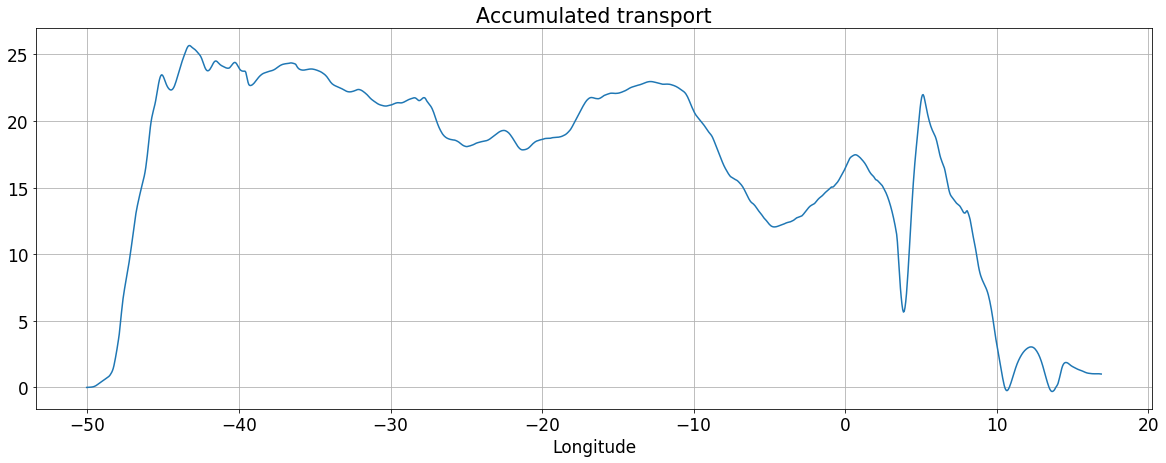

In [20]:
Int1 = section.u_normal*section.dx*section.dz/1e6
Inty2 = Int1.sum('z').cumsum('c').mean(dim = "time_counter")

fig, ax = plt.subplots()
ax.plot(lon2,Inty2)
plt.grid()
plt.title('Accumulated transport')
plt.xlabel('Longitude');

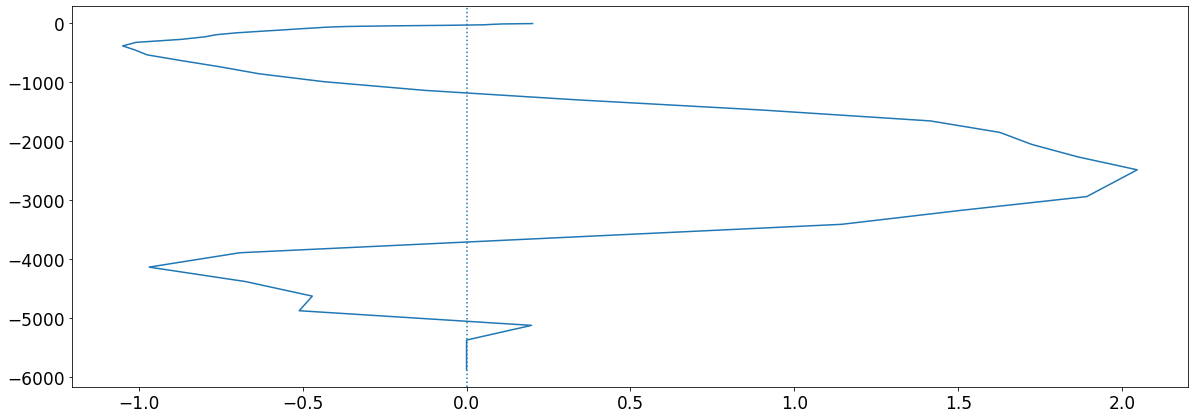

In [28]:
lsum_Int1=Int1.sum('c')
plt.plot(lsum_Int1[11,:],-lsum_Int1.z)
plt.axvline(x=0,linestyle='dotted');

In [24]:
lsum_Int1.head()

<xarray.DataArray (time_counter: 5, z: 5)>
array([[ 0.01559506,  0.01804427, -0.00154624, -0.16695186, -0.31226892],
       [-0.23722265, -0.22750318, -0.12525378, -0.11574194, -0.25088184],
       [-0.14038038, -0.12812051, -0.08719212, -0.05804318, -0.13263537],
       [-0.53227461, -0.58392758, -0.62342926, -0.64421386, -0.59135785],
       [-0.23906588, -0.30037762, -0.35020424, -0.39000786, -0.41861162]])
Coordinates:
  * z             (z) float64 3.047 9.454 16.36 23.9 32.21
  * time_counter  (time_counter) datetime64[ns] 2003-01-16T12:00:00 ... 2003-05-16T12:00:00

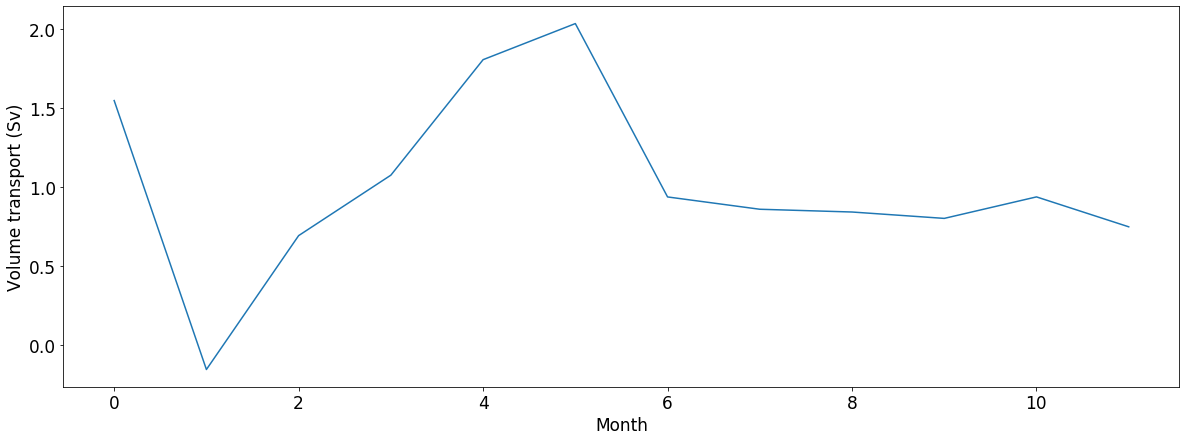

In [25]:
plt.plot(transport['trsp'])
plt.ylabel("Volume transport (Sv)");
plt.xlabel("Month");

In [29]:
section.c

<xarray.DataArray 'c' (c: 1359)>
array([4.690205e+03, 9.380410e+03, 1.407062e+04, ..., 6.451218e+06,
       6.456035e+06, 6.460852e+06])
Coordinates:
  * c        (c) float64 4.69e+03 9.38e+03 1.407e+04 ... 6.456e+06 6.461e+06

In [17]:
#U_along_section.min().values

In [18]:
#U_along_section.max().values

In [19]:
#U_along_section.mean("t").isel(z_c=10).values ## aqui tengo valores pero no se a que profundidad

In [34]:
#de_z = -1000

In [37]:
#zv = U_along_section.depth_c

In [20]:
#zv.values

In [21]:
#ide_z = (np.abs(zv-de_z)).argmin() 

In [22]:
#ide_z.values

In [23]:
#U_along_section.mean("t").isel(z_c=ide_z.values).values ## aqui tengo valores pero no se a que profundidad